# Data challenge: The clairvoyant constructor 

### The problem:
I'm working as a data scientist at a large construction company. In order to submit more competitive bids for contracts, the head of analytics and data science would like me to forcast core construction material costs. Currently, the company is able to purchase futures contracts in a material for up to six months in advance. 

**GOAL:**
- forecast the price of each commodity up to six months into the future 
- Understand when a commodity price is about to increase temporarily, in order to either buy the commodity early or wait until after the temporary increase.

### The data:
I have the price information (per unit, in dollars) for the company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years in csv format.


### The approach:
- Data QC (no major problems)
- Data pre-processing - interpolate data with more than 20% NaN (use Pandas interpolate for time series)
- Check if data is stationary (augmented Dick Fuller Test)
- If not stationary: perform BoxCox transformation - ALL DATA WAS STATIONARY HERE
- Use Facebook Prophet to forecast prices for the next 6 momths (183 days)
- Visualize forecast and trends 
- Cross validate model (MAE)
- Conclude when to buy


### Results, insights & conclusions:

#### RESULTS
PLYWOOD: plywood prices start to decrease (July 19) and reach a minimum at the end of August - The end of August should be a good time to be. Mid September prices will increase gain and reach another peak mid October and dip again , reaching another minimum Mid November -> Plywood: Buy end of August or Mid November
- Error forecast (MAPE): +- 30%

GLASS: Prices are at a local minimum and will slightly increase after Mid July, with reaching a maximum around Mid April -> Buy glass asap!
- Error forecast (MAPE): +- 15-18%

REBAR: Prices are at a local minimum and are increasing and will reach a maximum around the end of December -> Buy rebar asap! Next year buy rebar at the beginning of May
- Error forecast (MAPE): +- 40%

CONCRETE: Prices will reach a minimum around mid August and increas after and will reach a maximum around the beginning of June -> Buy concrete around mid August!
- Error forecast (MAPE): +- 30%

STEEL: Prices are at a local minimum and will increase, with reaching a maximum around Mid December -> Buy steel asap!
- Error forecast (MAPE): +- 25%

#### CONCLUSIONS
- Buy plywood end of August or Mid November
- Buy glass asap
- Buy concrete around mid August
- Buy steel asap
- Buy rebar asap - Next year buy rebar at the beginning of May
- No weekly trends were observed and data or the weekend was mostly missing

**NOTE: forecasted prices have a significant error (MAPE) - Prices of commodities are mostly influenced by supply and demand. However, exogenous factors such as political events, variations in weather or other acts of nature can play a significant role and are hard to predict or include in a prediction model, so introduce extra variance in any forecast - Forecasting the price direction of any raw material market is always a tricky business!**

## 1. Data pre-processing & EDA

In [21]:
'''
Global import statements
'''

# general import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
%matplotlib inline

#forcasting with FB prophet 
#- conda search fbprophet - to see all versions available
#when installing fbprophet - specify version 0.6, otherwise it will throw off an error when importing here
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics # Metrics to evaluate forecast
from fbprophet.plot import plot_cross_validation_metric # plot croosvalidation metric of prophet
#from holidays import WEEKEND, HolidayBase
#from dateutil.easter import easter
#from dateutil.relativedelta import relativedelta as rd

#test to check if data is stationary
# conda install -c conda-forge statsmodels=0.11.1
from statsmodels.tsa.stattools import adfuller

#boxcox transform data if not stationary
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import warnings
warnings.filterwarnings('ignore')

The data was supplied in excel format, I'll be importing the data here and will use Pandas to do the rest of the exploratory data analysis

### 1.1 Importing data & QC

#### Importing data

In [2]:
#reading the data into a pandas dataframe
df = pd.read_excel('construction_material_prices_2008_2018.xlsx')
df.head()

,Unnamed: 0,price_steel,price_rebar,price_glass,price_concrete,price_plywood
0,2007-01-01,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,NaN,NaN,NaN,NaN,NaN
2,2007-01-04,NaN,NaN,NaN,NaN,NaN
3,2007-01-05,NaN,NaN,NaN,NaN,NaN
4,2007-01-08,NaN,NaN,NaN,NaN,NaN


In [3]:
df.rename(columns={'Unnamed: 0':'date'}, inplace=True)

#### general QC - missing values

In [4]:
df.isnull().sum()

date                 0
price_steel        636
price_rebar       1296
price_glass       1473
price_concrete    1498
price_plywood      272
dtype: int64

In [5]:
# checking the number of entries, data types and presence of missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2945 non-null   datetime64[ns]
 1   price_steel     2309 non-null   float64       
 2   price_rebar     1649 non-null   float64       
 3   price_glass     1472 non-null   float64       
 4   price_concrete  1447 non-null   float64       
 5   price_plywood   2673 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 138.2 KB


A lot of missing values - shouldn't be a problem for a forcasting model so will leave it like this for now

#### Check for duplicates

In [6]:
# Check for duplicates
print('unique values vs duplicates:\t', df['date'].unique().shape)

unique values vs duplicates:	 (2945,)


no duplicates!

#### Check for outliers

In [7]:
df.describe()

,price_steel,price_rebar,price_glass,price_concrete,price_plywood
count,2309.000000,1649.000000,1472.000000,1447.000000,2673.000000
mean,12.611319,18.306339,29.997962,26.000636,12.775067
std,6.038862,8.587938,6.524622,7.314764,3.931698
min,3.062500,3.000000,16.000000,10.416667,5.000000
25%,8.500000,12.071429,25.000000,20.559028,10.125000
50%,10.500000,16.500000,29.000000,25.043478,12.125000
75%,14.833333,22.500000,35.000000,30.000000,14.333333
max,41.000000,55.000000,48.000000,50.000000,34.000000


In [130]:
df.tail(5)

,date,price_steel,price_rebar,price_glass,price_concrete,price_plywood
2940,2018-06-13,NaN,NaN,NaN,NaN,NaN
2941,2018-06-14,NaN,NaN,NaN,NaN,NaN
2942,2018-06-15,NaN,NaN,NaN,NaN,NaN
2943,2018-06-18,NaN,NaN,NaN,NaN,NaN
2944,2018-06-19,NaN,NaN,NaN,NaN,NaN


These values look reasonable - we can dive deeper using visualizations

#### slicing data

We need to forcast prices for each material seperately so lets slice the dataframe:

In [22]:
steel = df.loc[:,['date','price_steel']]
rebar = df.loc[:,['date','price_rebar']]
glass = df.loc[:,['date','price_glass']]
conc = df.loc[:,['date','price_concrete']]
ply = df.loc[:,['date','price_plywood']]

### 1.2 Visualizing prices throughout the years

#### Price trends over 9 years

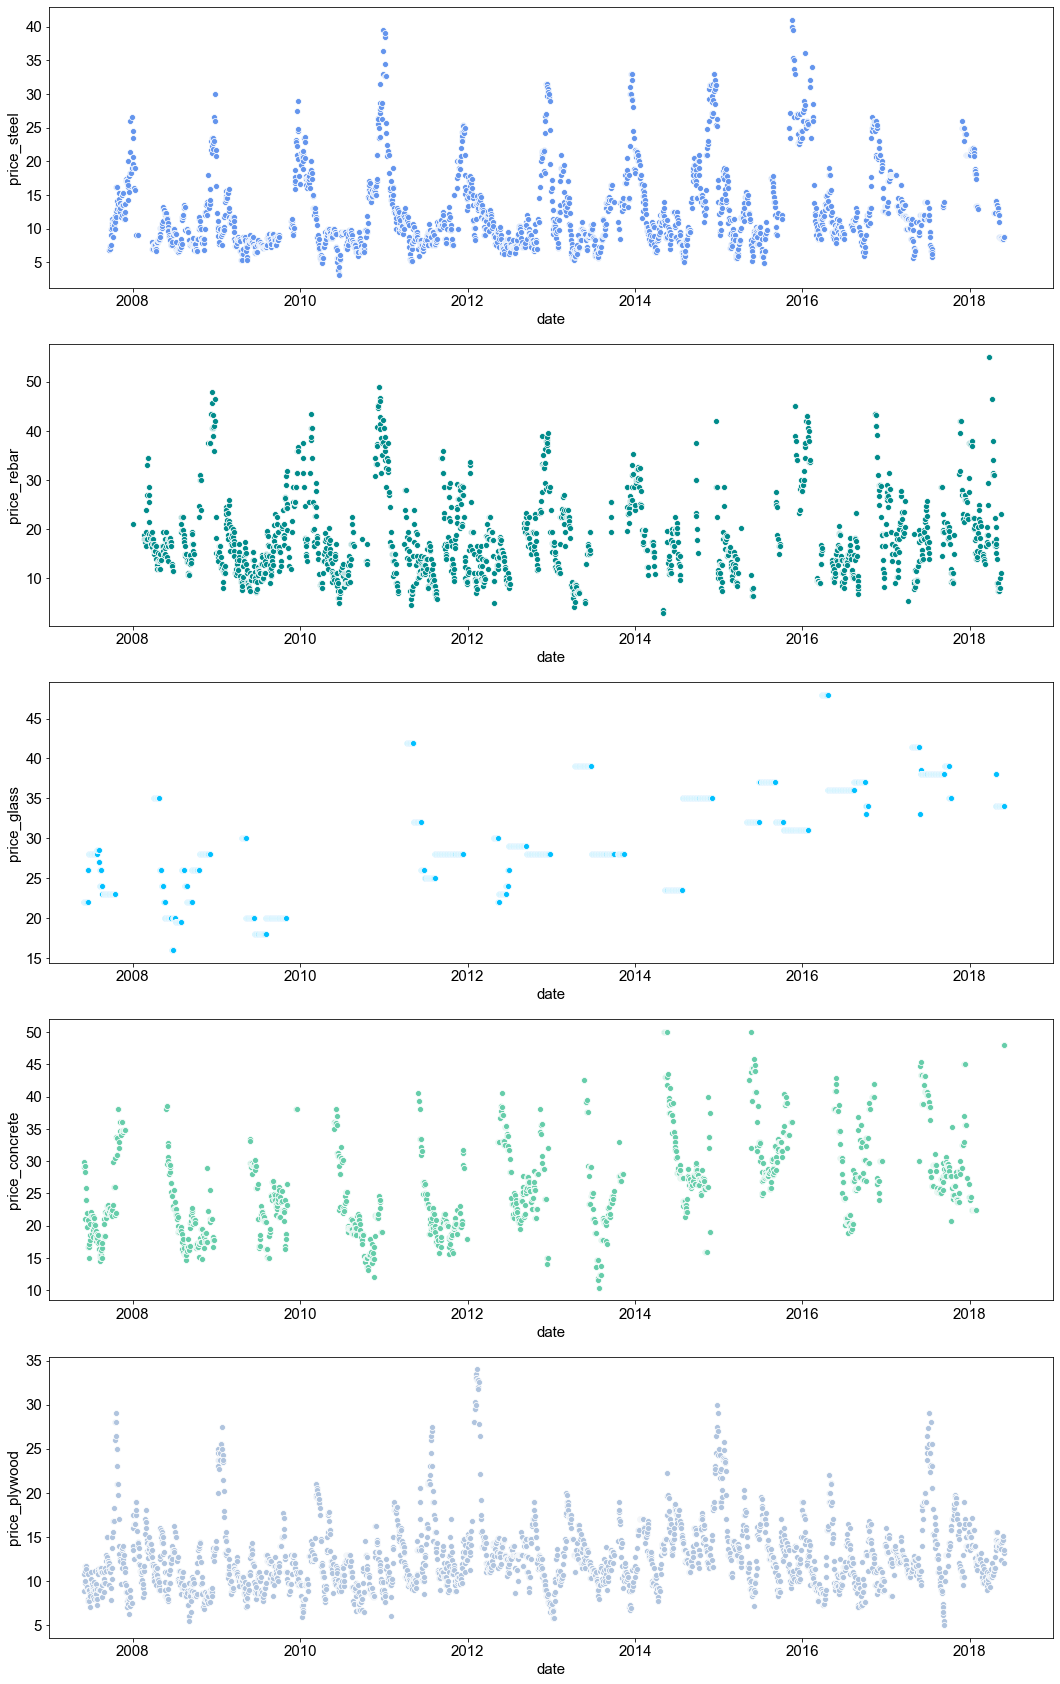

In [9]:
#plt styling
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size']=15
colors = ['#6495ED','#008B8B','#00BFFF','#66CDAA','#B0C4DE','#191970']


# to plot data
columns = ['price_steel', 'price_rebar', 'price_glass', 'price_concrete',
       'price_plywood']
dfs = [steel,rebar,glass,conc,ply]

#plotting scatter plots
fig, axes = plt.subplots(5,1, figsize=(18,30))

for i in range(len(columns)):
    p = sns.scatterplot('date', columns[i], data=dfs[i], color=colors[i], ax=axes[i])
    p.set_xlim(pd.Timestamp('2007-01-01'), pd.Timestamp('2019-01-01'))

To show trends a bit more clearly we can use line plots but we should keep in mind that we do have a lot of missing data

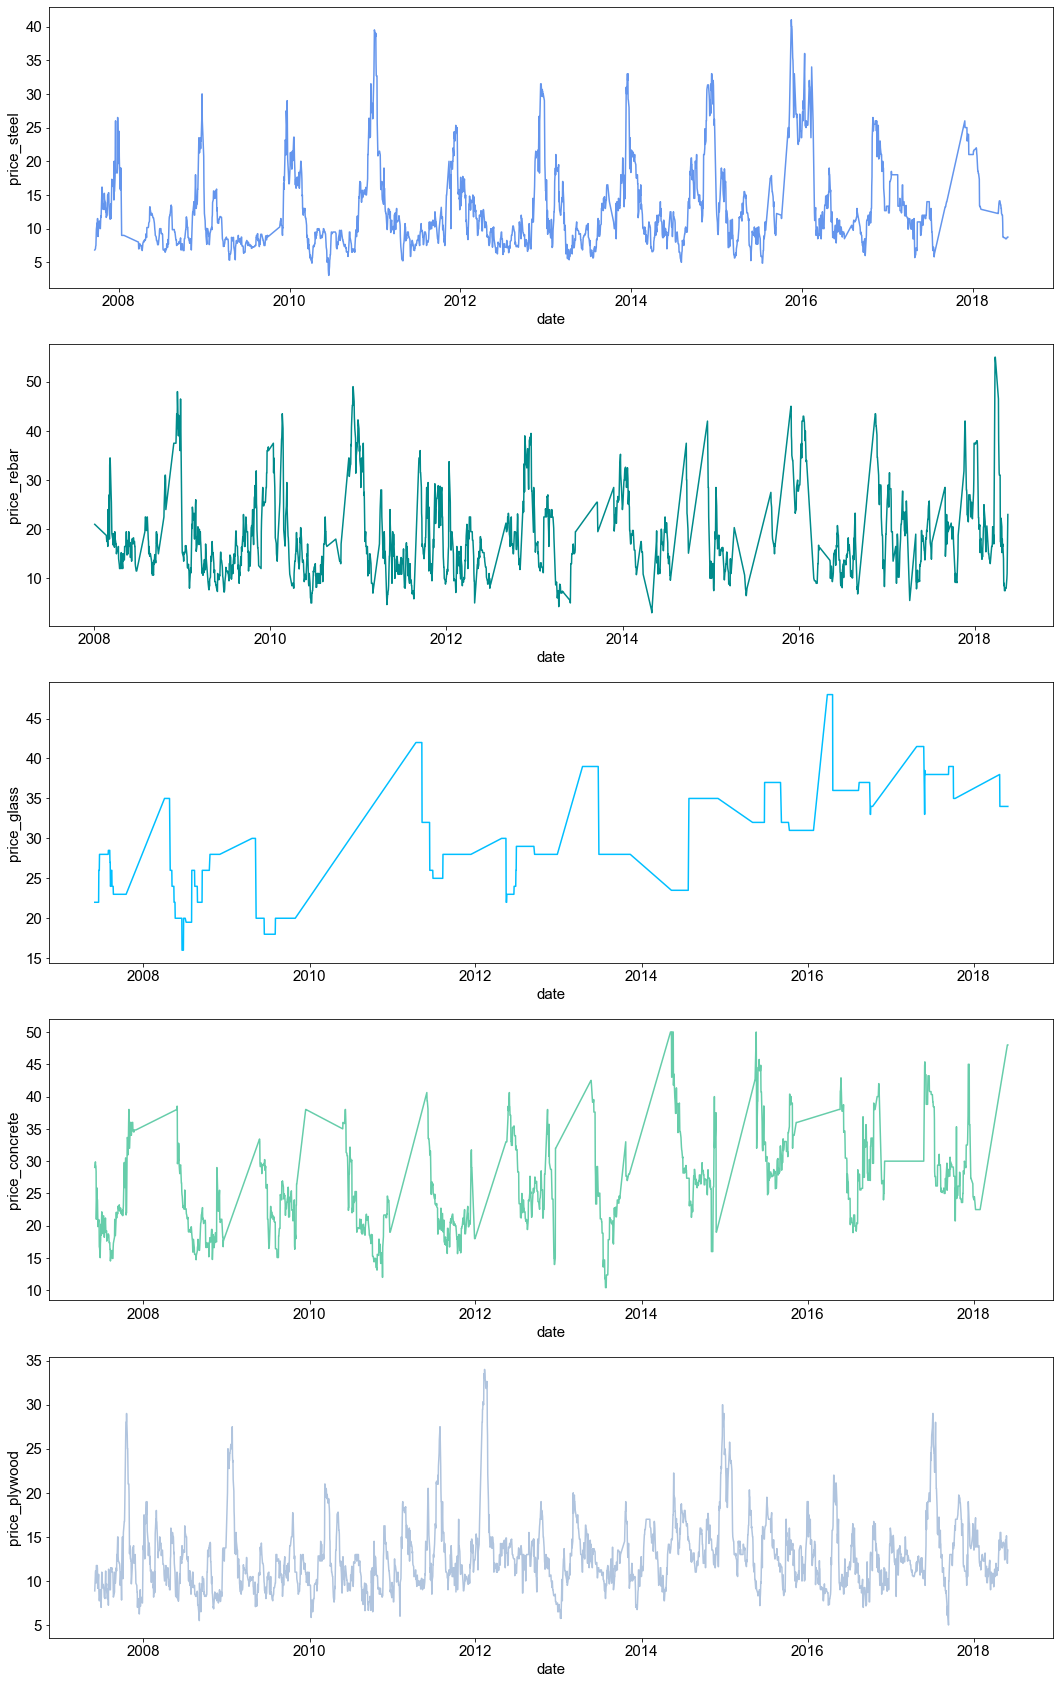

In [10]:
#plt styling
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size']=15
colors = ['#6495ED','#008B8B','#00BFFF','#66CDAA','#B0C4DE','#191970']

#plotting scatter plots
fig, axes = plt.subplots(5,1, figsize=(18,30))

for i in range(len(columns)):
    p = sns.lineplot('date', columns[i], data=dfs[i], color=colors[i], ax=axes[i])

Let's check the trends over 1 year

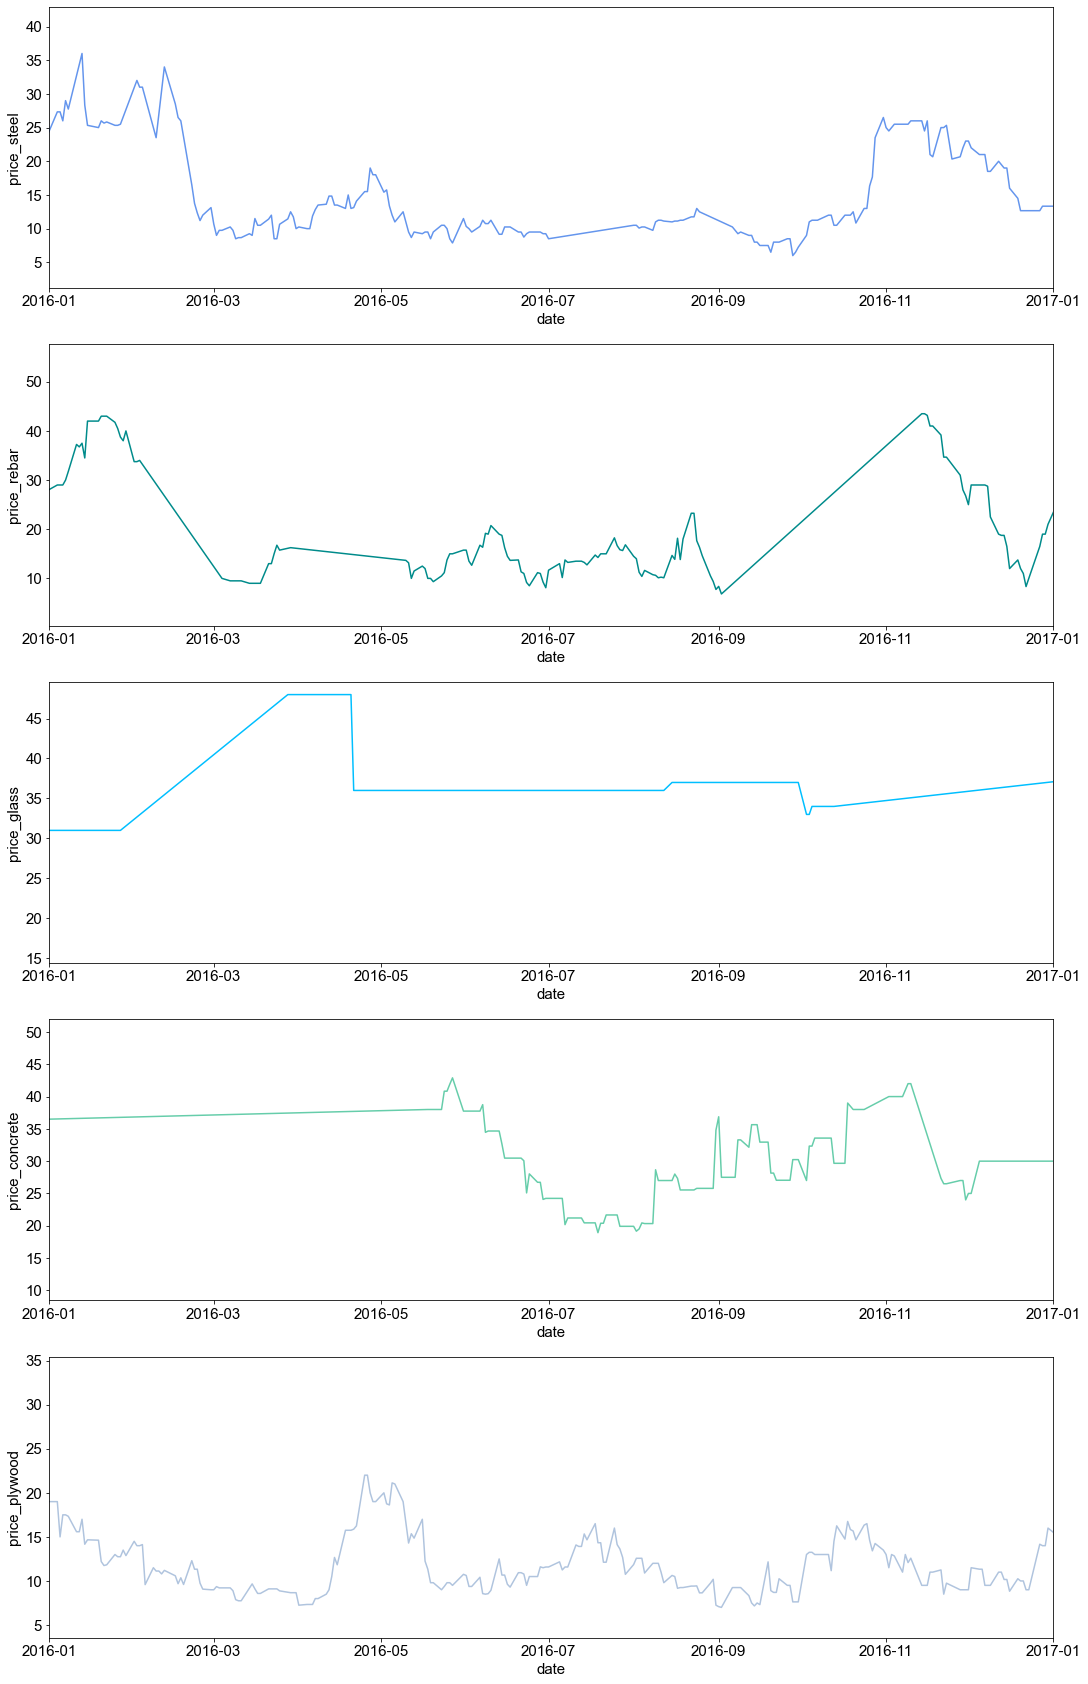

In [11]:
#plotting scatter plots
fig, axes = plt.subplots(5,1, figsize=(18,30))

for i in range(len(columns)):
    p = sns.lineplot('date', columns[i], data=dfs[i], color=colors[i], ax=axes[i])
    p.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))


## 2. Building a model to forcast future prices using FB prophet

Prophet is an open-source package (for both Python and R) for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well . Prophet is open source software released by Facebook’s core Data Science team. It is available for download on CRAN and PyPI.


The Prophet procedure is an additive regression model with four main components:
A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
A yearly seasonal component modeled using Fourier series.
A weekly seasonal component using dummy variables.
A user-provided list of important holidays.


Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.
The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

https://facebook.github.io/prophet/

In [123]:
'''
Functions for data pre-processing, model building with FB prophet, validation and plotting
'''


#function to prep the data for ingestion in prophet (not transfomed & not interpolated)
def prep_df(dfname,column_name):
    dfname.rename(columns={'date': 'ds', column_name: 'y'},inplace=True)      

#function for dfs with a lot of NaN, interpolates NaN, preps data for ingestion and returns the new df       
def prep_interpolate(dfname,column_name): 
    dftosr = pd.Series(dfname[column_name].values, index=dfname['date']) #convert df to a series
    dftosr.interpolate(method='time',axis='index',inplace=True) #impute NaNs using Pandas interpolate 'time'
    #dftosr.isnull().sum()
    new_df = pd.DataFrame({'date':dftosr.index, column_name:dftosr.values})
    new_df.rename(columns={'date': 'ds', column_name: 'y'},inplace=True)
    return new_df   

#function that fits data to a previously defined prophet model and returns a dataframe with forecasted prices for 183 days
def build_model(df_name, m_df_name): #m_df_name is the name of the prophet model that was defined 
    #m_df_name.add_country_holidays(country_name = 'US') #include US holidays    
    m_df_name.fit(df_name)    
    future = m_df_name.make_future_dataframe(periods = 183, freq = 'd') #create 183 extra days for forecasting purpose i.e till end of 2019    
    return m_df_name.predict(future); # forecast data using our transformed data

#This plots a detail of the forcast for 2018/01 - 2019/01 - forcast starting from 2018/06
def plot_detail_forecast(forecast_name,df_name,material):
    plt.figure(figsize=(15,6))
    plt.plot(forecast_name.ds, forecast_name.yhat)
    plt.scatter(df_name.ds, df_name['y'], color=colors[1], alpha=0.5, s=3)
    # plotting upper/lower bounds
    plt.fill_between(forecast_name.ds, forecast_name.yhat_lower,forecast_name.yhat_upper,
                     color='gray', alpha=0.5)
    title_f = 'Forecast of '+material
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Forecast in dollars', fontsize=14)
    plt.title(title_f, fontsize=20)
    plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-01-01'))   

#function that runs a cross-validation of the prophet model and plots a graph of metric
def cross_val(material, metric,model_name): #model_name = m_df_name from previous function, name of the prophet model    
    cv = cross_validation(model_name, horizon='182 days', initial ='1820 days')
    #printout_metrics = performance_metrics(cv) 
    #printout_metrics.tail(20)
    title = metric + ' for forecast of '+material
    plot_cross_validation_metric(cv, metric=metric)
    plt.xlabel('Horizon in days', fontsize=16)
    plt.ylabel(metric, fontsize=16)
    plt.title(title, fontsize=20)
     

### 2.1 plywood price prediction

I'll start off with forcasting prices for plywood. This data set has less than 10% NaN, which prophet should be able to handle.

#### 2.1.1 Data pre-processing 

In [24]:
prep_df(ply ,'price_plywood') 

In [25]:
ply.head(5)

,ds,y
0,2007-01-01,NaN
1,2007-01-03,NaN
2,2007-01-04,NaN
3,2007-01-05,NaN
4,2007-01-08,NaN


#### 2.1.2 Augmented Dickey-Fuller test (check if data is stationary)

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.


Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).


**p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.**

**p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.**



In [128]:
# the adfuller test can't handle NaN so I interpolate the data before performing the test
ply = df.loc[:,['date','price_plywood']]
ply_AF = prep_interpolate(ply, 'price_plywood')
ply_AF = ply_AF.dropna() 

#use statsmodel adfuller test and report p value
X = ply_AF['y']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.167301
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We can reject the Null hypothesis, the data is stationary and doesn't need to be transformed

#### 2.1.3 Use Fb Prophet to predict 6 months into the future

In [26]:
#define a model for plywood with prophet
m_ply = Prophet(interval_width=0.90) #90% confidence internal with yearly seasonality

In [28]:
#forecast 6 months using the pre-defined function
forecast_ply = build_model(ply, m_ply)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


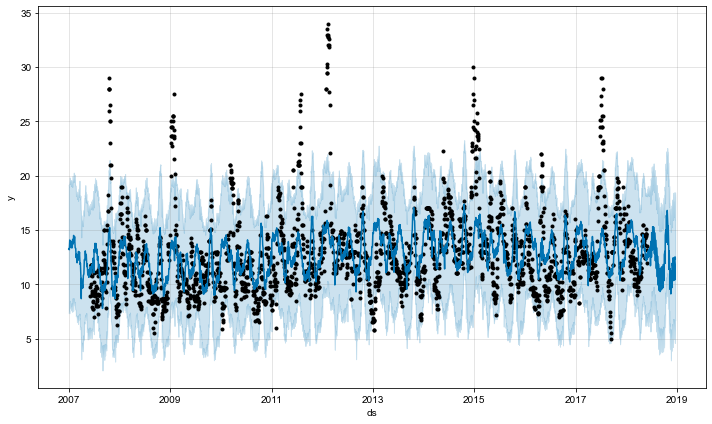

In [30]:
#This command plots the model's forecast along with the real values
m_ply.plot(forecast_ply);

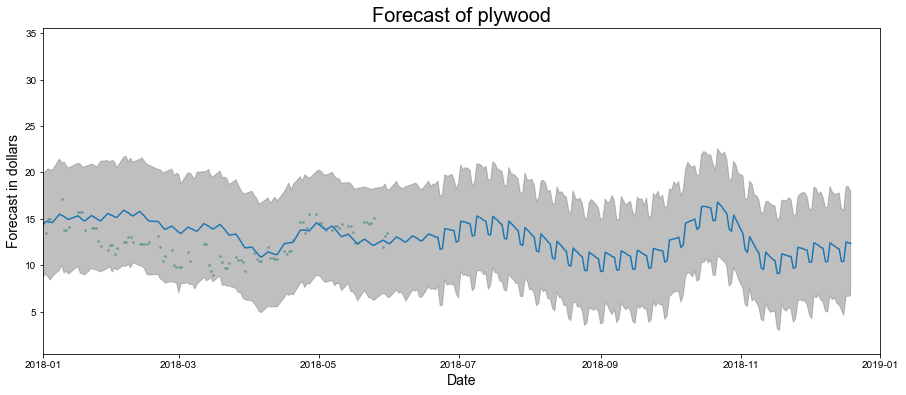

In [47]:
#Use function to plot a detail of the forecasted period
plot_detail_forecast(forecast_ply, ply,'plywood')

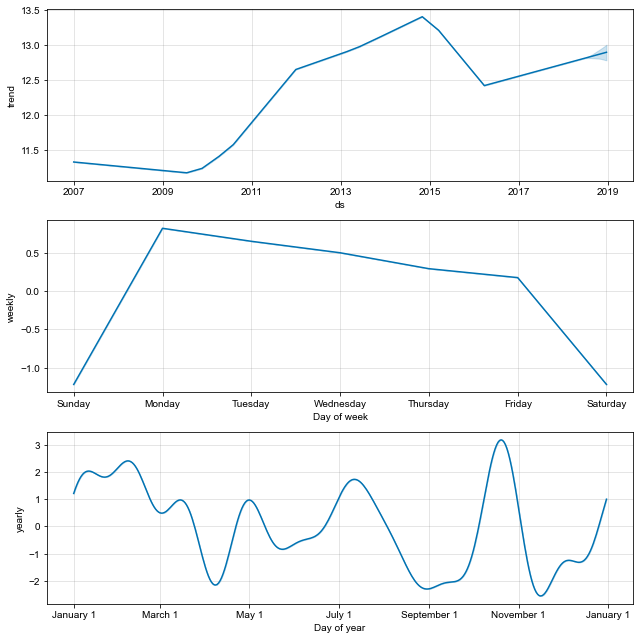

In [48]:
#Use this command to plot detailed plots of the prediction
m_ply.plot_components(forecast_ply);

#### 2.1.4 Running cross-validation on the model

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.
The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.

The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAE. Dots show the absolute percent error for each prediction. The blue line shows the MAE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 3USD.

https://facebook.github.io/prophet/docs/diagnostics.html

INFO:fbprophet:Making 23 forecasts with cutoffs between 2012-06-07 00:00:00 and 2017-11-30 00:00:00


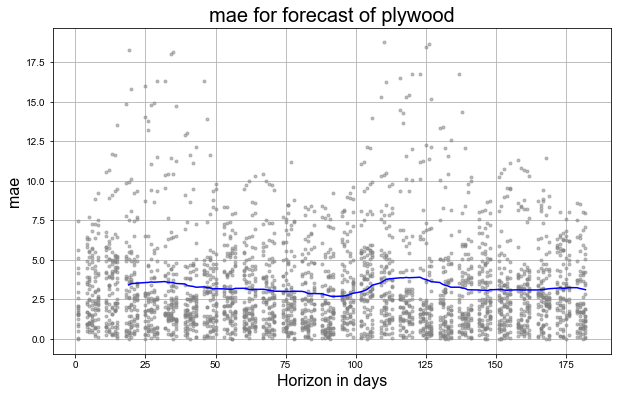

In [127]:
#use the pre-defined function to run cross-validation on the model 
cross_val('plywood','mae',m_ply)

INFO:fbprophet:Making 23 forecasts with cutoffs between 2012-06-07 00:00:00 and 2017-11-30 00:00:00


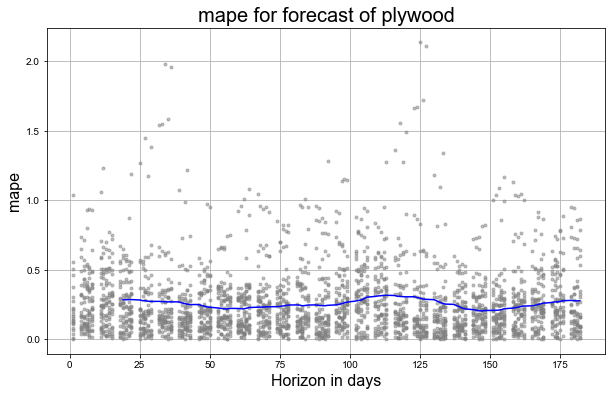

In [131]:
#use the pre-defined function to run cross-validation on the model 
cross_val('plywood','mape',m_ply)

#### 2.1.5 Conclusions

plywood prices start to decrease (July 19) and reach a minimum at the end of August - The end of August should be a good time to be. Mid September prices will increase gain and reach another peak mid October and dip again , reaching another minimum Mid November -> **Plywood: Buy end of August or Mid November**

### 2.2 steel price prediction

#### 2.2.1 Data pre-processing 

In [33]:
steel = df.loc[:,['date','price_steel']]
# prep the data and use prophet to forecast
prep_df(steel ,'price_steel') 

In [34]:
steel.head(5)

,ds,y
0,2007-01-01,NaN
1,2007-01-03,NaN
2,2007-01-04,NaN
3,2007-01-05,NaN
4,2007-01-08,NaN


#### 2.2.2 Augmented Dickey-Fuller test (check if data is stationary)

In [129]:
steel = df.loc[:,['date','price_steel']]
steel_AF = prep_interpolate(steel, 'price_steel')
steel_AF = steel_AF.dropna() 

X = steel_AF['y']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.398259
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We can reject the Null hypothesis, the data is stationary and doesn't need to be transformed

#### 2.2.3 Use Fb Prophet to predict 6 months into the future

In [35]:
m_steel = Prophet(interval_width=0.90)#90% confidence internal with yearly seasonality

In [36]:
# use function to build a prophet model of the df_name
forecast_steel = build_model(steel,m_steel)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


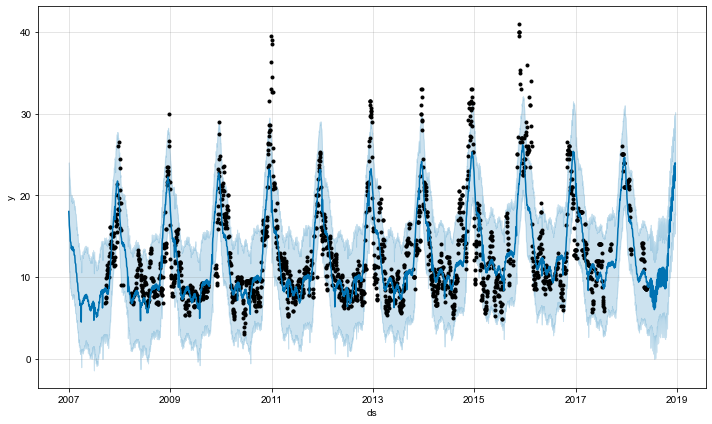

In [37]:
#This command plots the models forecast along with the real values
m_steel.plot(forecast_steel);

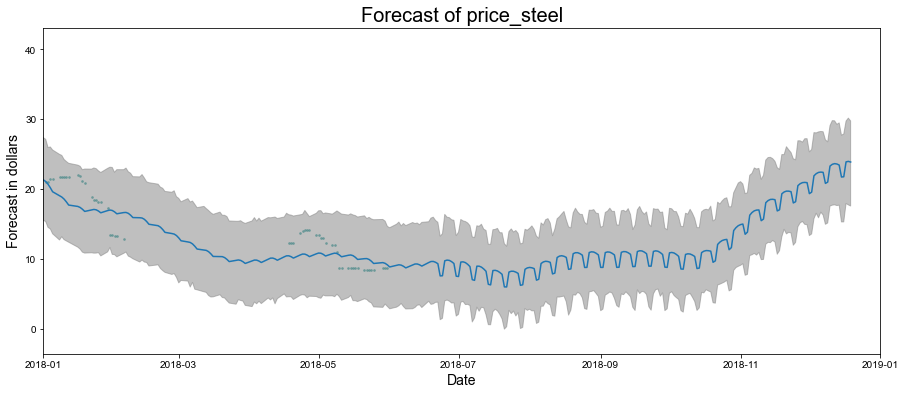

In [49]:
#Use function to plot a detail of the forecasted period
plot_detail_forecast(forecast_steel, steel,'price_steel')

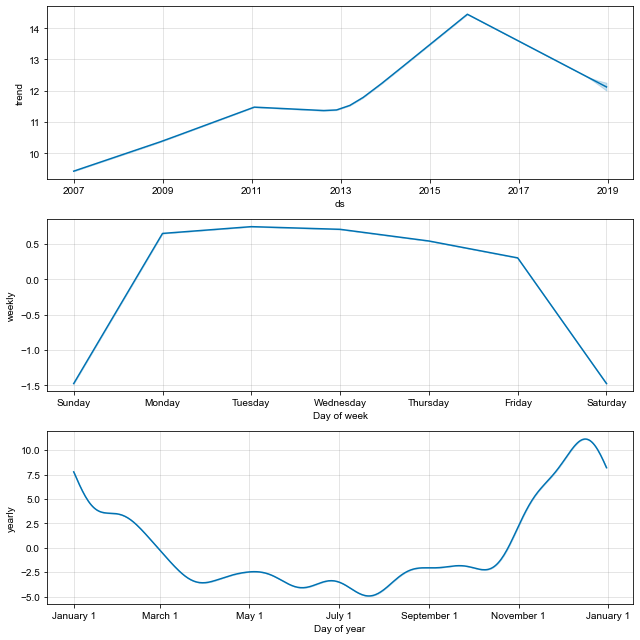

In [50]:
#Use this command to plot detailed plots of the prediction
m_steel.plot_components(forecast_steel);

#### 2.2.4 Running cross-validation on the model

INFO:fbprophet:Making 21 forecasts with cutoffs between 2012-12-06 00:00:00 and 2017-11-30 00:00:00


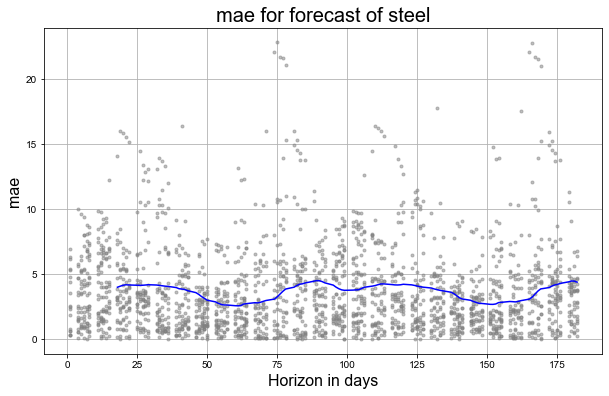

In [126]:
#use the pre-defined function to run cross-validation on the model 
cross_val('steel','mae',m_steel)

INFO:fbprophet:Making 21 forecasts with cutoffs between 2012-12-06 00:00:00 and 2017-11-30 00:00:00


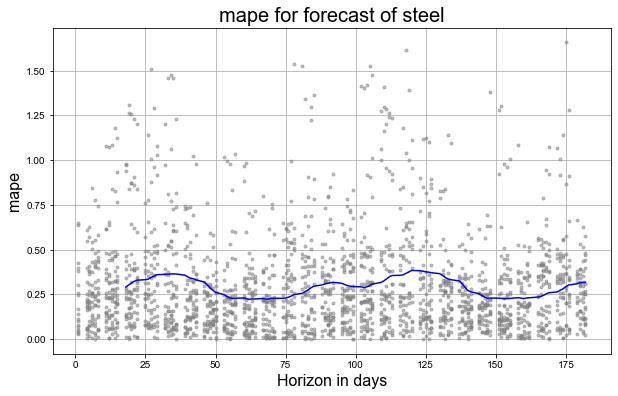

In [132]:
#use the pre-defined function to run cross-validation on the model 
cross_val('steel','mape',m_steel)

#### 2.2.4  Conclusions steel:

Prices are at a local minimum and will increase, with reaching a maximum around Mid December **-> Buy steel asap!**

### 2.3 glass price prediction

#### 2.3.1 Data pre-processing

More than half of the data is missing for glass prices - I'll be using Pandas interpolate function that imputes values fot time series

In [61]:
glass = df.loc[:,['date','price_glass']]
glass_new = prep_interpolate(glass, 'price_glass')

In [62]:
glass_new.head()

,ds,y
0,2007-01-01,NaN
1,2007-01-03,NaN
2,2007-01-04,NaN
3,2007-01-05,NaN
4,2007-01-08,NaN


In [ ]:
glass.info()

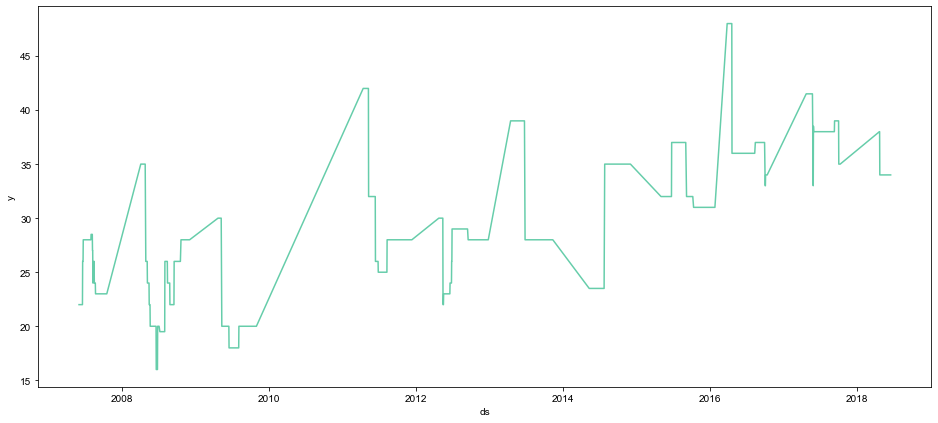

In [65]:
fig, axes = plt.subplots(1,1, figsize=(16,7))

p = sns.lineplot('ds', 'y', data=glass_new, color=colors[3])
#p.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))

#### 2.3.2 Augmented Dickey-Fuller test (check if data is stationary)

In [66]:
glass_new = glass_new.dropna() #drop rows with missing values

In [67]:
glass_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2840 entries, 105 to 2944
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2840 non-null   datetime64[ns]
 1   y       2840 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 66.6 KB


In [69]:
X = glass_new['y']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
#from https://machinelearningmastery.com/time-series-data-stationary-python/

ADF Statistic: -2.916737
p-value: 0.043436
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We can reject the Null hypothesis, the data is stationary and doesn't need to be transformed

#### 2.3.3 Use Fb Prophet to predict 6 months into the future

In [70]:
m_glass = Prophet(interval_width=0.90)#90% confidence internal with yearly seasonality

In [71]:
# use function to build a prophet model of the df_name
forecast_glass = build_model(glass_new,m_glass)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


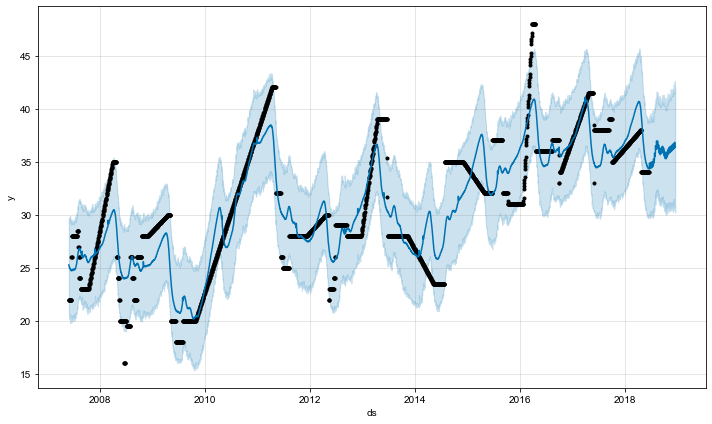

In [72]:
#This command plots the models forecast along with the real values
m_glass.plot(forecast_glass);

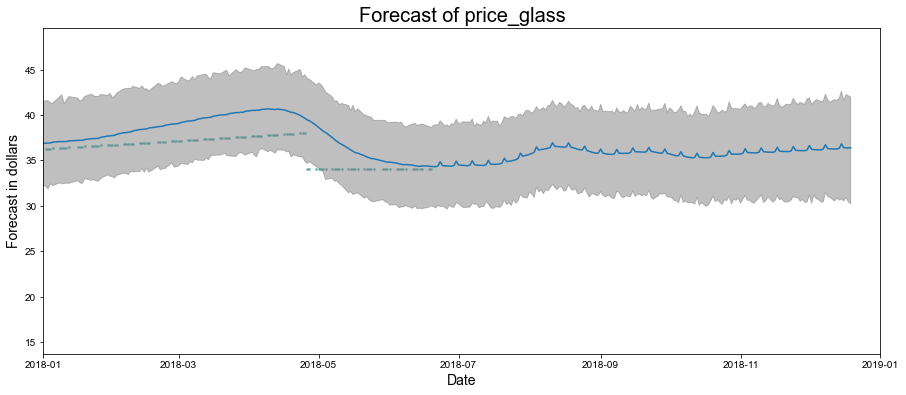

In [73]:
#Use function to plot a detail of the forecasted period
plot_detail_forecast(forecast_glass, glass_new,'price_glass')

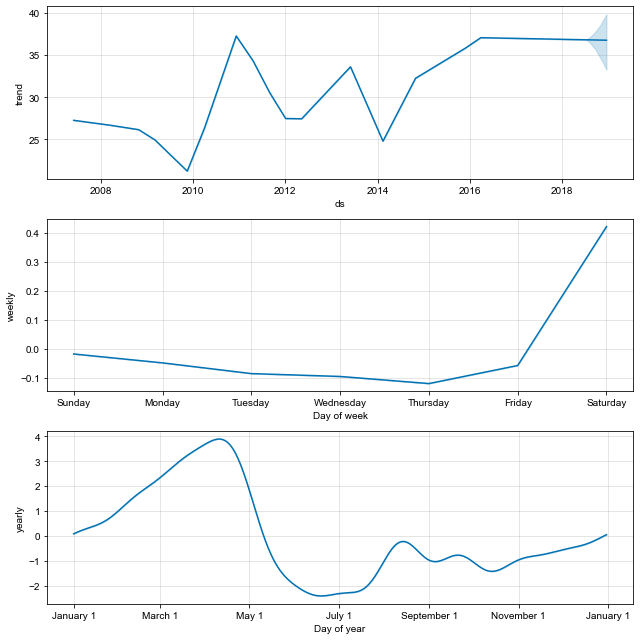

In [74]:
#Use this command to plot detailed plots of the prediction
m_glass.plot_components(forecast_glass);

#### 2.3.4 Running cross-validation on the model

INFO:fbprophet:Making 23 forecasts with cutoffs between 2012-06-26 00:00:00 and 2017-12-19 00:00:00


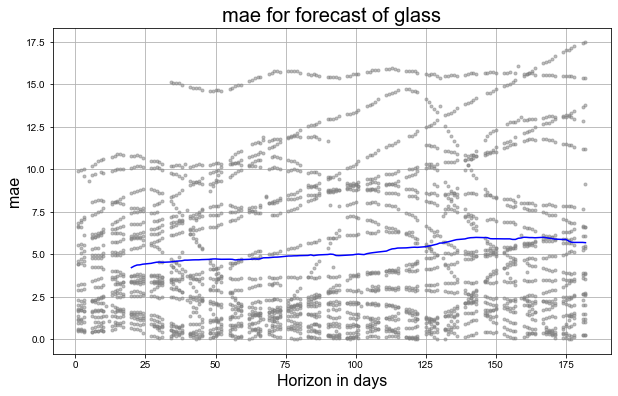

In [125]:
#use the pre-defined function to run cross-validation on the model 
cross_val('glass','mae',m_glass)

INFO:fbprophet:Making 23 forecasts with cutoffs between 2012-06-26 00:00:00 and 2017-12-19 00:00:00


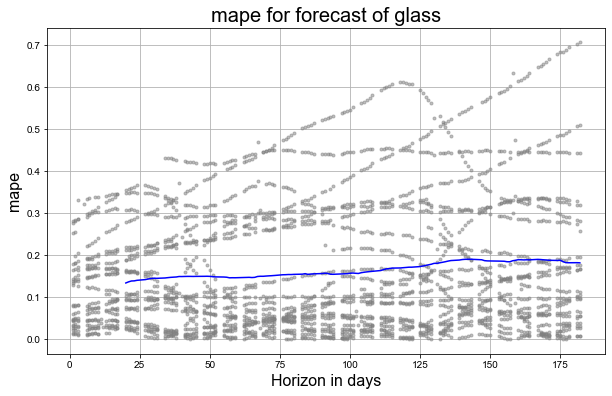

In [133]:
#use the pre-defined function to run cross-validation on the model 
cross_val('glass','mape',m_glass)

#### 2.3.5 Conclusions glass:

Prices are at a local minimum and will slightly increase after Mid July, with reaching a maximum around Mid April **-> Buy glass asap!**

### 2.4 Rebar price prediction

#### 2.4.1 Data pre-processing

In [89]:
rebar = df.loc[:,['date','price_rebar']]

In [90]:
# A lot of NaNs so interpolate missing values
rebar_new = prep_interpolate(rebar, 'price_rebar')

In [78]:
rebar_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2945 non-null   datetime64[ns]
 1   y       2687 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 46.1 KB


#### 2.4.2 Augmented Dickey-Fuller test (check if data is stationary)

In [79]:
rebar_new = rebar_new.dropna() #drop rows with missing values

In [80]:
rebar_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2687 entries, 258 to 2944
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2687 non-null   datetime64[ns]
 1   y       2687 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 63.0 KB


In [81]:
X = rebar_new['y']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.327678
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We can reject the Null hypothesis, the data is stationary and doesn't need to be transformed

#### 2.4.3 Use Fb Prophet to predict 6 months into the future

In [91]:
m_rebar = Prophet(interval_width=0.90)#90% confidence internal with yearly seasonality

In [92]:
# use function to build a prophet model of the df_name
forecast_rebar = build_model(rebar_new,m_rebar)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


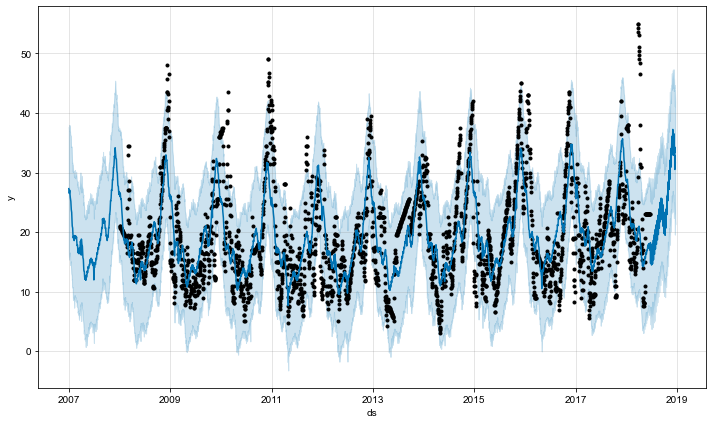

In [93]:
#This command plots the models forecast along with the real values
m_rebar.plot(forecast_rebar);

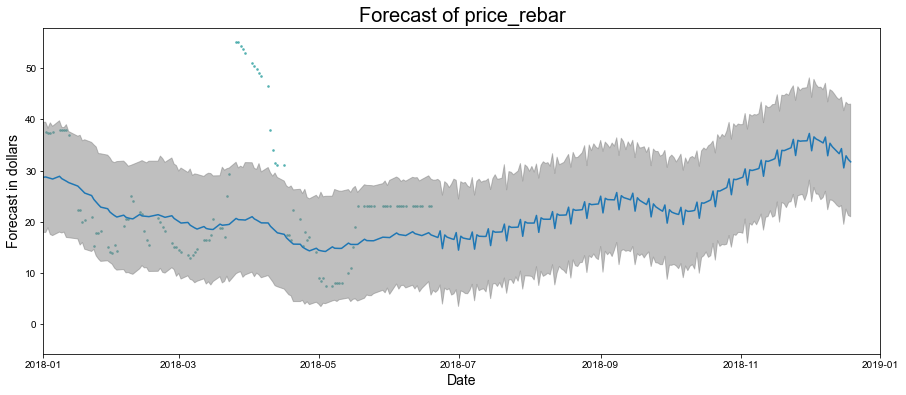

In [85]:
#Use function to plot a detail of the forecasted period
plot_detail_forecast(forecast_rebar, rebar_new,'price_rebar')

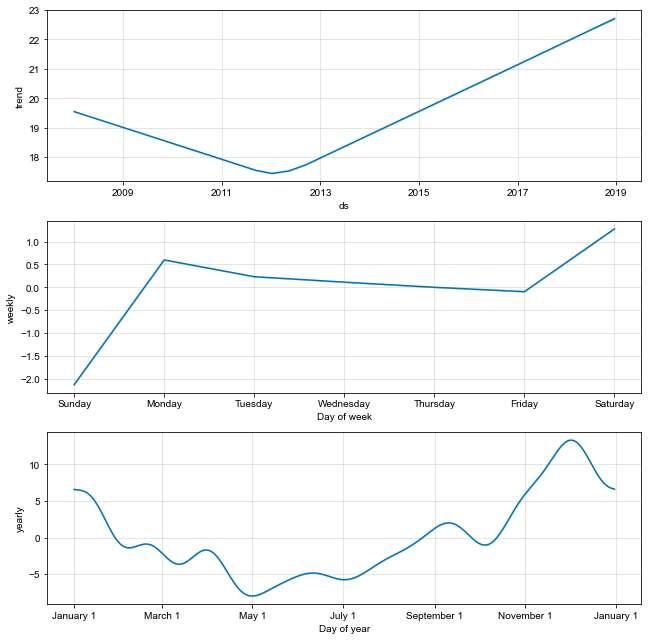

In [86]:
#Use this command to plot detailed plots of the prediction
m_rebar.plot_components(forecast_rebar);

#### 2.4.4 Running cross-validation on the model

INFO:fbprophet:Making 34 forecasts with cutoffs between 2009-09-29 00:00:00 and 2017-12-19 00:00:00


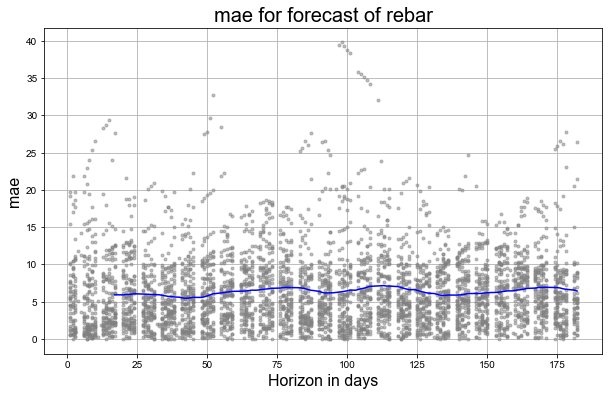

In [122]:
#use the pre-defined function to run cross-validation on the model 
cross_val('rebar','mae',m_rebar)

INFO:fbprophet:Making 20 forecasts with cutoffs between 2013-03-26 00:00:00 and 2017-12-19 00:00:00


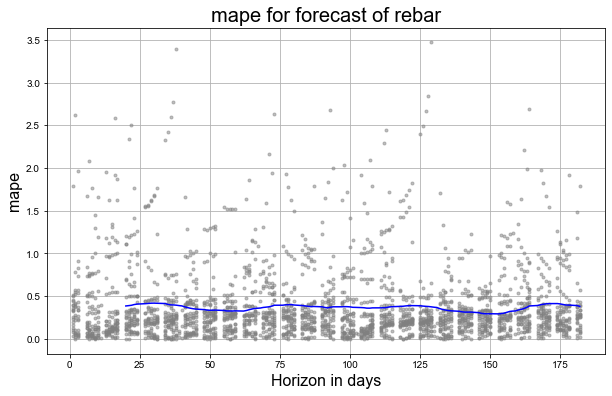

In [134]:
#use the pre-defined function to run cross-validation on the model 
cross_val('rebar','mape',m_rebar)

#### 2.4.5 Conclusions rebar:

Prices are at a local minimum and are increasing and will reach a maximum around the end of December -> **Buy rebar asap! Next year buy rebar at the beginning of May**

### 2.5 Concrete price prediction

#### 2.5.1 Data pre-processing

In [103]:
conc = df.loc[:,['date','price_concrete']]

In [104]:
conc_new = prep_interpolate(conc, 'price_concrete')

In [105]:
conc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2945 non-null   datetime64[ns]
 1   y       2840 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 46.1 KB


#### 2.5.2 Augmented Dickey-Fuller test (check if data is stationary)

In [106]:
conc_new=conc_new.dropna()

In [107]:
conc_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2840 entries, 105 to 2944
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2840 non-null   datetime64[ns]
 1   y       2840 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 66.6 KB


In [108]:
X = conc_new['y']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.744935
p-value: 0.003524
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We can reject the Null hypothesis, the data is stationary and doesn't need to be transformed

#### 2.5.3 Use Fb Prophet to predict 6 months into the future

In [109]:
m_conc = Prophet(interval_width=0.90)#90% confidence internal with yearly seasonality

In [110]:
# use function to build a prophet model of the df_name
forecast_conc = build_model(conc_new,m_conc)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


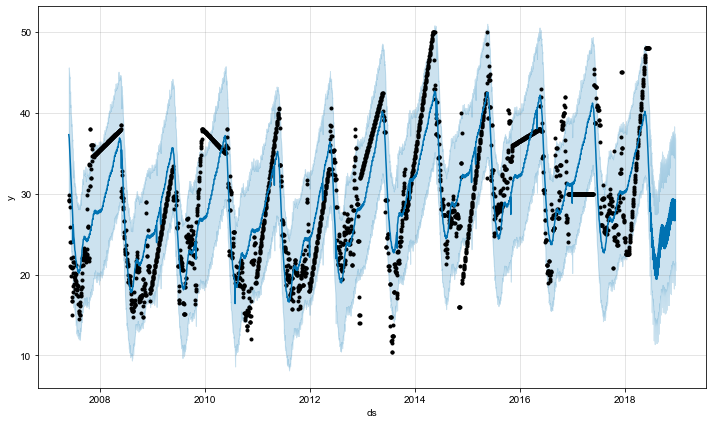

In [111]:
#This command plots the models forecast along with the real values
m_conc.plot(forecast_conc);

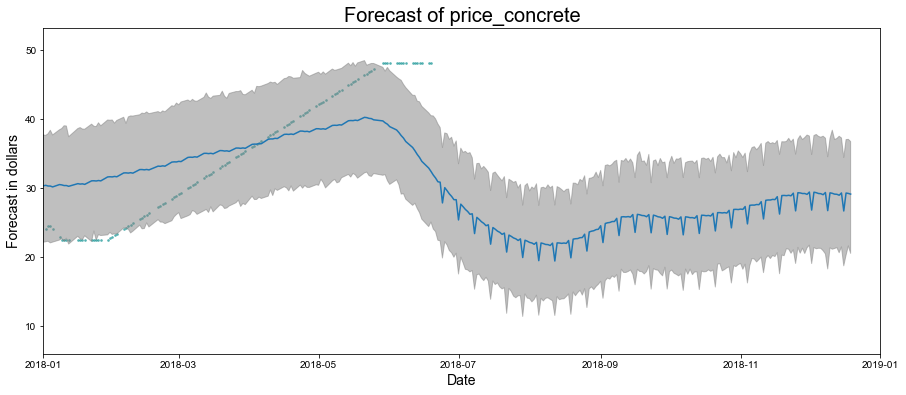

In [112]:
#Use function to plot a detail of the forecasted period
plot_detail_forecast(forecast_conc, conc_new,'price_concrete')

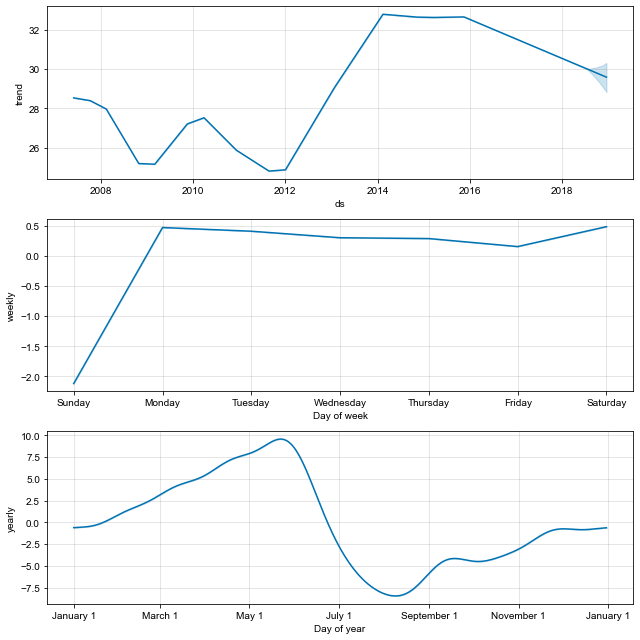

In [113]:
#Use this command to plot detailed plots of the prediction
m_conc.plot_components(forecast_conc);

#### 2.5.4 Running cross-validation on the model

INFO:fbprophet:Making 23 forecasts with cutoffs between 2012-06-26 00:00:00 and 2017-12-19 00:00:00


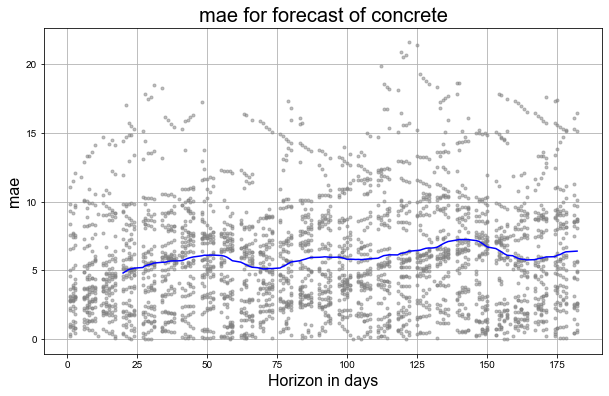

In [124]:
#use the pre-defined function to run cross-validation on the model 
cross_val('concrete','mae',m_conc)

INFO:fbprophet:Making 23 forecasts with cutoffs between 2012-06-26 00:00:00 and 2017-12-19 00:00:00


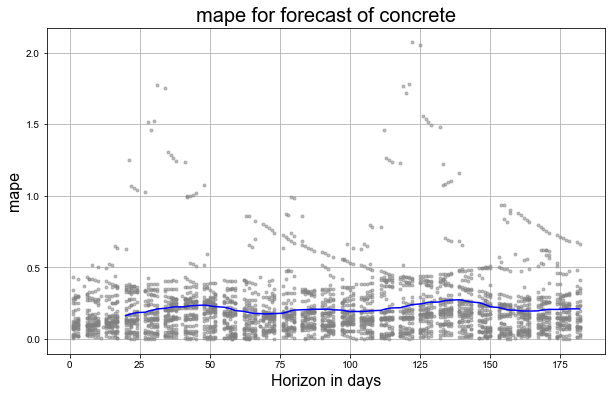

In [135]:
#use the pre-defined function to run cross-validation on the model 
cross_val('concrete','mape',m_conc)

#### 2.5.5 Conclusions concrete:

Prices will reach a minimum around mid August and increas after and will reach a maximum around the beginning of June -> **Buy concrete around mid August!**

## 4. Conclusions

PLYWOOD: plywood prices start to decrease (July 19) and reach a minimum at the end of August - The end of August should be a good time to be. Mid September prices will increase gain and reach another peak mid October and dip again , reaching another minimum Mid November -> Plywood: Buy end of August or Mid November
Error forecast (MAPE): +- 30%

GLASS: Prices are at a local minimum and will slightly increase after Mid July, with reaching a maximum around Mid April -> Buy glass asap!
Error forecast (MAPE): +- 15-18%

REBAR: Prices are at a local minimum and are increasing and will reach a maximum around the end of December -> Buy rebar asap! Next year buy rebar at the beginning of May
Error forecast (MAPE): +- 40%

CONCRETE: Prices will reach a minimum around mid August and increas after and will reach a maximum around the beginning of June -> Buy concrete around mid August!
Error forecast (MAPE): +- 30%

STEEL: Prices are at a local minimum and will increase, with reaching a maximum around Mid December -> Buy steel asap!
Error forecast (MAPE): +- 25%


**NOTE: forecasted prices can have a significant error - this is not rocket science, prices of commodities are mostly influenced by supply and demand. However, exogenous factors, such as political events, variations in weather or acts of nature, can play a significant role and are hard to predict or include in a prediction model, so introduce extra variance  - Forecasting the price direction of any raw material market is always a tricky business**

## 5. Addendum

### 5.1 forecasting with boxcox transformed ply values

Often in forecasting, you’ll explicitly choose a specific type of power transform to apply to the data to remove noise before feeding the data into a forecasting model (e.g. a log transform or square root transform, amongst others). However, it can sometimes be difficult to determine which type of power transform is appropriate for your data. This is where the Box-Cox Transform comes in.

Box-Cox Transforms are data transformations that evaluate a set of lambda coefficients (λ) and selects the value that achieves the best approximation of normality.

The scipy.stats Python module provides a built-in Box-Cox Transform method, called boxcox. The boxcox method returns a positive dataset transformed by a Box-Cox power transformation. The boxcox method will find the λ that maximizes the log-likelihood function and will return it as the second output argument (lam).

See the following resources:

https://mode.com/example-gallery/forecasting_prophet_python_cookbook/

http://www.anoj.net/data-sci/2019/6/02/sales-forecasting-using-prophet-and-python


In [ ]:
ply = df.loc[:,['date','price_plywood']]    

In [ ]:
def boxcox_prep(dfname,column_name):
    dfname['ds'] = dfname['date']
    dfname['y'] = dfname[column_name]
    dfname = dfname.set_index('date')  
    
boxcox_prep(ply ,'price_plywood')    
    
# Apply Box-Cox Transform to value column and assign to new column y
ply['y'], lam = boxcox(ply['y'])

In [ ]:
lam

In [ ]:
ply.tail(20)

In [ ]:
m = Prophet(interval_width=0.90) #90% confidence internal with yearly seasonality
m.add_country_holidays(country_name = 'US') #include US holidays
m.fit(ply)
future = m.make_future_dataframe(periods = 183, freq = 'd') #create 365 extra days for forecasting purpose i.e till end of 2019
forecast_t = m.predict(future); # forecast data using our transformed data

In [ ]:
m.plot_components(forecast_t);

In [ ]:
forecast = pd.DataFrame()
forecast['ds'] = forecast_t['ds']
forecast[['yhat','yhat_upper','yhat_lower']] = forecast_t[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

m.history['y_t'] = m.history['y']
m.history['y'] = m.history['price_plywood']

ply['y_t'] = ply['y']
ply['y'] = ply['price_plywood']

In [ ]:
m.plot(forecast);

In [ ]:
m.plot(forecast_t);  #Light blue space is the 90% confidence interval

In [ ]:
metric_df = forecast.set_index('ds')[['yhat']].join(ply.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
r2_score(metric_df.y, metric_df.yhat), mean_squared_error(metric_df.y, metric_df.yhat), mean_absolute_error(metric_df.y, metric_df.yhat)

lambda is 8

In [ ]:
plywood_cv = cross_validation(m, horizon='365 days',initial='3650 days', period='180 days')
plywood_metrics = performance_metrics(plywood_cv)
plywood_metrics.head(5)